## Transformer架构

### 文本嵌入层(输入部分)

In [21]:
import torch
#预定义的网络层torch.nn，卷积层，lstm层，embeding层不需要再造轮子
import torch.nn as nn
import torch.nn.functional as F
#数学计算工具包
import math


from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy
import numpy as np

In [22]:

#定义Embeddings类来实现文本嵌入层，这里s说明代表两个一模一样的嵌入层，共享参数
#该类继承nn.Module
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        """类的初始化函数，有两个参数，d_model:词的嵌入维度，vocab：指词表的大小"""
        #接着就是使用super的方式指明继承nn.Module的初始化函数
        super(Embeddings,self).__init__()
        #调用nn中预定义层Embedding，获得一个词嵌入对象self.lut
        self.lut=nn.Embedding(vocab,d_model)
        #将d_model传入类中
        self.d_model=d_model

    def forward (self,x):
        """前向传播逻辑，参数x代表输入给模型的文本通过词汇映射后的张量"""

        #将x传给self.lut并于根号下的self.d_model相乘作为结果返回
        return self.lut(x)*math.sqrt(self.d_model)


nn.Embedding演示

In [23]:
embedding=nn.Embedding(10,3)#单词总数，嵌入的维度
input=torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[-1.1129, -1.2660,  0.1931],
         [ 1.5493, -0.3214, -0.1060],
         [ 0.2230, -0.7124, -1.3569],
         [-0.6257,  0.4260, -0.0631]],

        [[ 0.2230, -0.7124, -1.3569],
         [ 1.9426,  0.3629, -0.8504],
         [ 1.5493, -0.3214, -0.1060],
         [-0.5450, -0.4102,  0.3398]]], grad_fn=<EmbeddingBackward0>)

实例化参数

In [24]:
#定义词嵌入的维度是512
d_model=512
#定义词表的大小
vocab=1000

输入参数

In [25]:
#输入x是一个使用Variable封装的长整型张量，形状是2*4
x=Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))


调用

In [26]:
emb=Embeddings(d_model,vocab)
embr=emb(x)
print(embr)
print(embr.shape)

tensor([[[ 42.2289,  37.3839, -34.9574,  ...,  -9.4627,  -1.0813,  -3.3262],
         [ 16.6429, -28.2031,  -7.7107,  ...,  -7.7170,   4.6460,   3.5568],
         [ -2.3282,  25.4542,  13.6503,  ..., -14.8311,  16.6831, -26.7782],
         [-27.9241,   5.0939, -20.4859,  ...,  47.1386,  29.1109,  -6.1928]],

        [[  0.7222,  31.8948, -11.3373,  ...,  -1.1982,  29.0171,  35.2815],
         [ 19.4589, -61.1226, -13.5037,  ...,   3.7066, -17.5038, -23.9446],
         [ -8.0557,  13.5085,   1.5048,  ...,  -1.2847, -61.0856, -30.6789],
         [-47.9644,   6.4821, -23.9107,  ..., -40.9443, -21.7802,  -2.5255]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


#### 位置编码器
将词汇位置不同可能会产生不同语义的信息加到词嵌入张量中，以弥补位置信息的缺失


In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        """d_model词嵌入维度，dropout：置零比率(遗忘比例？)，max_len：每个句子的最大长度"""
        super(PositionalEncoding, self).__init__()

        #实例化Dropout层
        self.dropout=nn.Dropout(p=dropout) 

        #初始化一个位置编码矩阵，矩阵大小为max_len*d_model
        self.pe=torch.zeros(max_len,d_model)

        #初始化一个绝对位置矩阵，在这里用它的索引去表示
        #所以使用arange方法获得一个连续自然数向量，然后再使用unsqueeze方法拓展向量维度
        position=torch.arange(0,max_len).unsqueeze(1)

        #绝对位置矩阵初始化后，要将位置信息加入到位置编码矩阵中
        #将max_len*1的绝对位置矩阵变换成max_len*d_model形状
        #下面是一个经典的实现方法
        
        div_term=torch.exp(torch.arange(0,d_model,2)*
                           -(math.log(10000.0)/d_model))
        self.pe[:,0::2]=torch.sin(position*div_term)
        self.pe[:,1::2]=torch.cos(position*div_term)

        #目前pe矩阵的维度还不够，需要拓展维度，使用的是unsqueeze拓展
        self.pe=self.pe.unsqueeze(0)

        #最后把pe位置编码矩阵注册成为模型的buffer，确保模型保存后重加载时一同被加载
        self.register_buffer=('pe',self.pe)

    def forward(self,x):
        x=x+Variable(self.pe[:,:x.size(1)],
                     requires_grad=False)
        
        return self.dropout(x)






nn.Dropout演示

In [28]:
m=nn.Dropout(p=0.2)
input=torch.randn(4,5)
output=m(input)
output

tensor([[-0.0351,  0.1582, -0.0435, -1.6702,  0.9170],
        [ 0.1682, -1.3049,  0.1954,  1.1506,  0.8317],
        [-0.0000,  0.2437,  0.1497, -0.2508,  0.0000],
        [ 0.0435,  0.4875, -0.0230, -0.1227, -0.1521]])

torch.unsqueeze演示

In [29]:
x=torch.tensor([1,2,3,4])
print(x)
print(torch.unsqueeze(x,0))
print(torch.unsqueeze(x,1))

tensor([1, 2, 3, 4])
tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


调用

In [30]:
d_model=512
dropout=0.1
max_len=60
x=embr


In [31]:
pe=PositionalEncoding(d_model,dropout,max_len)
pe_result=pe(x)
print(pe_result)
print(pe_result.shape)

tensor([[[ 46.9210,   0.0000, -38.8415,  ...,  -9.4030,  -1.2015,  -2.5846],
         [  0.0000, -30.7364,  -7.6542,  ...,  -7.4633,   0.0000,   5.0631],
         [ -1.5766,  27.8200,   0.0000,  ..., -15.3679,  18.5370, -28.6425],
         [-30.8700,   4.5599, -22.4898,  ...,  53.4874,  32.3458,  -5.7698]],

        [[  0.8024,  36.5497, -12.5970,  ...,  -0.2202,  32.2412,  40.3128],
         [ 22.5560, -67.3136, -14.0909,  ...,   5.2296, -19.4485, -25.4940],
         [ -7.9404,  14.5470,   2.7124,  ...,  -0.3164, -67.8727, -32.9766],
         [-53.1370,   6.1024, -26.2951,  ..., -44.3825, -24.1999,  -1.6950]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


#### 绘制词汇向量中特征的分布曲线

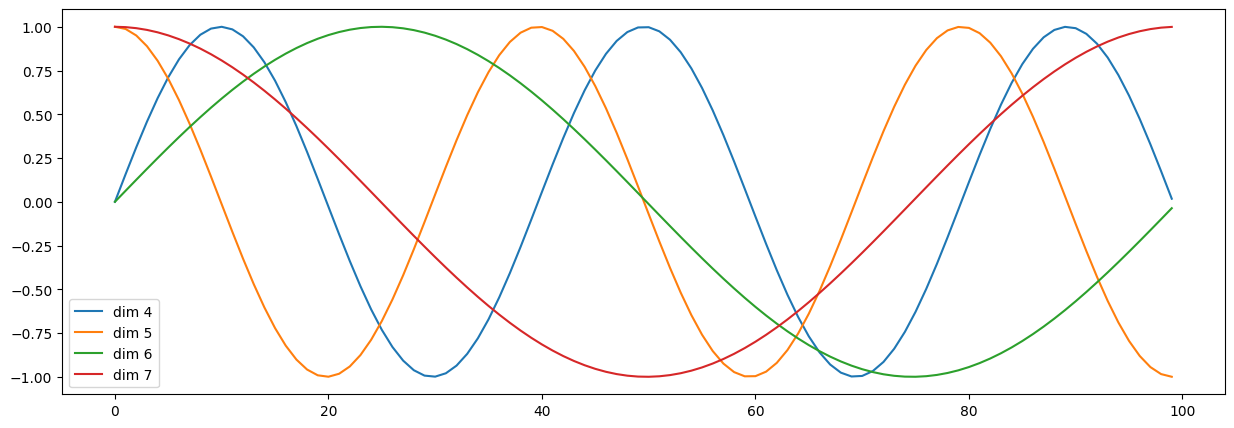

In [32]:
#创建一张15*5的画布
plt.figure(figsize=(15,5))
#实例化PositionalEncoding类
pe=PositionalEncoding(20,0)

#然后向pe传入被Variable封装的tensor，这样pe会直接执行 forward函数
#而且这个tensor里的数值都是0，被处理后相当于位置编码张量
y=pe(Variable(torch.zeros(1,100,20)))

#然后定义画布的横纵坐标，纵坐标是某一个词汇中的某些特征在不同长度下对应的值
#因为总共有20维，可以任意查看维度的值
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())

plt.legend(["dim %d" %p for p in [4,5,6,7]])

输出效果分析：
每条颜色的曲线代表某一个词汇中的特征在不同位置的含义
保证同一词汇随着所在位置不同它对应位置嵌入向量会发生变化
正弦波和余弦波的值域范围都是1到-1，这很好的控制了嵌入数值的大小，有助于梯度的快速计算

将置零比率改为0.1

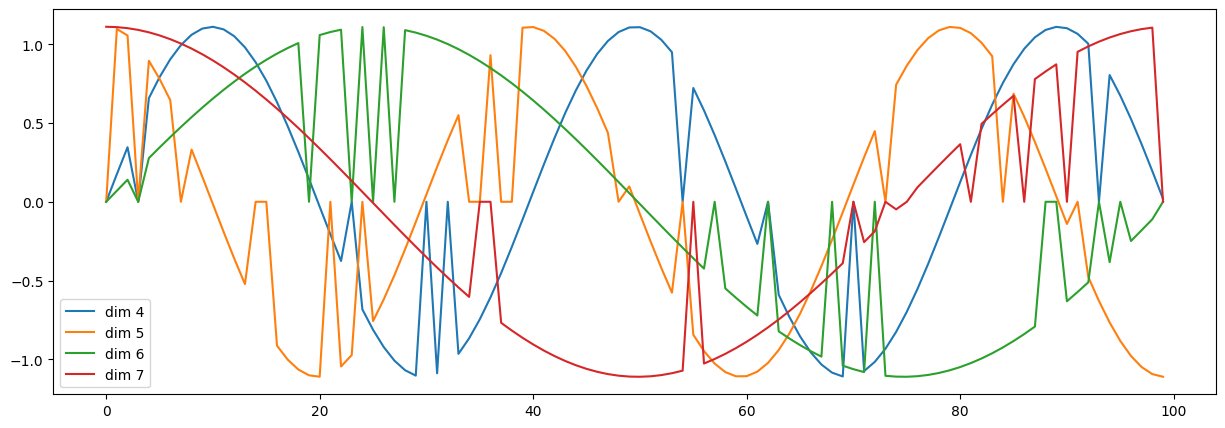

In [33]:
#创建一张15*5的画布
plt.figure(figsize=(15,5))
#实例化PositionalEncoding类
pe=PositionalEncoding(20,0.1)

#然后向pe传入被Variable封装的tensor，这样pe会直接执行 forward函数
#而且这个tensor里的数值都是0，被处理后相当于位置编码张量
y=pe(Variable(torch.zeros(1,100,20)))

#然后定义画布的横纵坐标，纵坐标是某一个词汇中的某些特征在不同长度下对应的值
#因为总共有20维，可以任意查看维度的值
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())

plt.legend(["dim %d" %p for p in [4,5,6,7]])

### 编码器

#### 掩码张量

用1和0的元素来表示位置被遮掩或者不被遮掩
作用：主要应用在attention中，避免未来的信息被错误的提前利用

In [34]:
def subsequent_mask(size):
    """生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，他的最后两维形成一个方阵"""
    attn_shape=(1,size,size)

    #然后使用np.ones方法向这个形状中添加1元素，形成上三角阵，最后为了节约空间
    #再将其中的数据类型变为无符号8位整型uint8
    subsequent_mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')

    #最后在将numpy类型转化为tensor时，用1-进行翻转操作
    return torch.from_numpy(1-subsequent_mask)


In [35]:
size=5
sm=subsequent_mask(size)
print(sm)

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


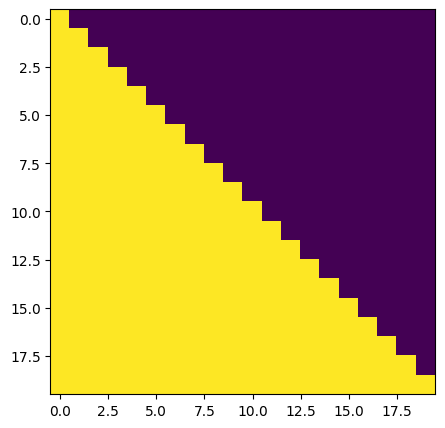

In [36]:
#可视化
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])#降维，用二维去画图

通过观察可视化方阵，黄色是1的部分，这里代表的是遮掩，紫色表示没有被遮掩的信息，横坐标代表目标词汇的位置，总纵坐标代表可查看的位置。
0的位置可以看到全为黄色，说明第一次词还没有产生，未来的结果不会对第一次的结果产生影响，第5次可以看到1到4的。


#### 注意力机制

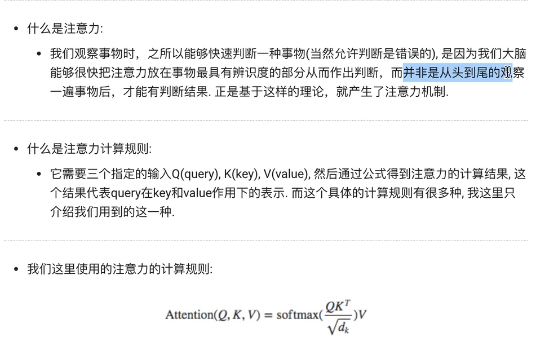

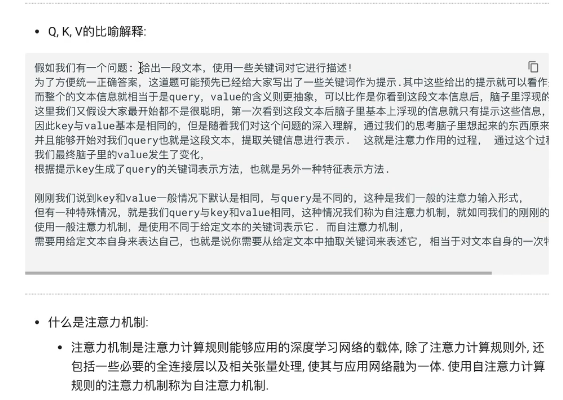
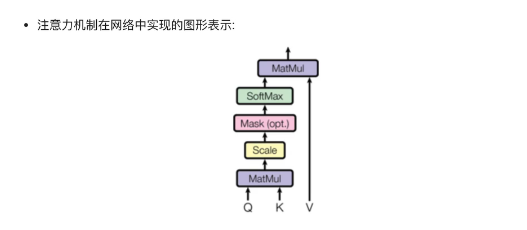

#### 代码分析

In [40]:
def attention(query,key,value,mask=None,dropout=None):
    """Q,K,V三个必要的参数，mask：掩码参量，dropout是nn.Dropout层的实例化对象"""
    #首先去query的最后一位的大小，一般情况下就等同于词嵌入维度
    d_k=query.size(-1)
    #按照注意力计算公式，得到注意力得分张量
    scores=torch.matmul(query,key.transpose(-2,-1)) / math.sqrt(d_k)#将key的最后两个维度进行转置
    #判断是否使用掩码张量
    if mask is not None:
        #使用tensor的masked_fill方法，将掩码张量和scores张量每一个位置一一比较，如果掩码张量处于0
        #则对应scores的张量用-1e9来替换
        scores=scores.masked_fill(mask==0,-1e9)

    #对scores的最后一维进行softmax操作，使用F.softmax方法
    p_attn=F.softmax(scores,dim=-1)

    #判断是否使用dropout
    if dropout is not None:
        p_attn=dropout(p_attn)
    
    #最后根据公式得到结果，返回query和注意力张量
    return torch.matmul(p_attn,value),p_attn
        


简单的测试

In [41]:
query=key=value=pe_result
attn,p_attn=attention(query,key,value)
print(attn)
print(attn.shape)
print(p_attn)
print(p_attn.shape)

tensor([[[ 46.9210,   0.0000, -38.8415,  ...,  -9.4030,  -1.2015,  -2.5846],
         [  0.0000, -30.7364,  -7.6542,  ...,  -7.4633,   0.0000,   5.0631],
         [ -1.5766,  27.8200,   0.0000,  ..., -15.3679,  18.5370, -28.6425],
         [-30.8700,   4.5599, -22.4898,  ...,  53.4874,  32.3458,  -5.7698]],

        [[  0.8024,  36.5497, -12.5970,  ...,  -0.2202,  32.2412,  40.3128],
         [ 22.5560, -67.3136, -14.0909,  ...,   5.2296, -19.4485, -25.4940],
         [ -7.9404,  14.5470,   2.7124,  ...,  -0.3164, -67.8727, -32.9766],
         [-53.1370,   6.1024, -26.2951,  ..., -44.3825, -24.1999,  -1.6950]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 512])
tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)
torch.Size([2, 4, 4])


In [43]:
query=key=value=pe_result
mask=Variable(torch.zeros(2,4,4))
attn,p_attn=attention(query,key,value,mask)
print(attn)
print(attn.shape)
print(p_attn)
print(p_attn.shape)

tensor([[[  3.6186,   0.4109, -17.2464,  ...,   5.3133,  12.4203,  -7.9835],
         [  3.6186,   0.4109, -17.2464,  ...,   5.3133,  12.4203,  -7.9835],
         [  3.6186,   0.4109, -17.2464,  ...,   5.3133,  12.4203,  -7.9835],
         [  3.6186,   0.4109, -17.2464,  ...,   5.3133,  12.4203,  -7.9835]],

        [[ -9.4298,  -2.5286, -12.5676,  ...,  -9.9224, -19.8200,  -4.9632],
         [ -9.4298,  -2.5286, -12.5676,  ...,  -9.9224, -19.8200,  -4.9632],
         [ -9.4298,  -2.5286, -12.5676,  ...,  -9.9224, -19.8200,  -4.9632],
         [ -9.4298,  -2.5286, -12.5676,  ...,  -9.9224, -19.8200,  -4.9632]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 512])
tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.250

#### 多头注意力机制